In [1]:
import matplotlib.pyplot as plt
import pandas as pd

import soundscapy as sspy
from soundscapy.databases import isd
from soundscapy.surveys import LANGUAGE_ANGLES, PAQ_IDS, rename_paqs

# Working with Soundscape Survey Data

## Introduction

This tutorial provides a comprehensive guide to working with soundscape survey data using the `Soundscapy` package. We'll cover loading, validating, cleaning, and processing survey data, with a focus on the International Soundscape Database (ISD) format.

### Learning Objectives

By the end of this tutorial, you will be able to:
- Load and validate soundscape survey data
- Perform data quality checks and handle missing values
- Calculate ISO coordinates from PAQ ratings
- Filter and group data by various criteria
- Work with different survey formats and scales
- Handle multi-language data using language-specific angles

Let's begin by importing the necessary libraries:

## 1. Loading Soundscape Survey Data

Soundscapy provides several ways to load soundscape survey data. The most common approach is to use the built-in functions for loading the International Soundscape Database (ISD).

In [2]:
# Load the ISD dataset included with Soundscapy
data = isd.load()

# Display basic information about the dataset
print(f"Dataset shape: {data.shape}")
print(f"Number of locations: {data['LocationID'].nunique()}")
print(f"Number of records: {data['RecordID'].nunique()}")
print(f"PAQ columns: {PAQ_IDS}")

Dataset shape: (3589, 142)
Number of locations: 26
Number of records: 2664
PAQ columns: ['PAQ1', 'PAQ2', 'PAQ3', 'PAQ4', 'PAQ5', 'PAQ6', 'PAQ7', 'PAQ8']


### Loading from Zenodo

You can also load the ISD dataset directly from Zenodo, which allows you to access different versions of the dataset:

In [3]:
# Load a specific version of the ISD dataset from Zenodo
# Note: This requires an internet connection
# data_zenodo = isd.load_zenodo(version="v1.0.1")
# print(f"Zenodo dataset shape: {data_zenodo.shape}")

### Loading Your Own Data

If you have your own soundscape survey data, you can load it using pandas and then process it with Soundscapy. The key is to ensure that your data includes the PAQ columns (PAQ1-PAQ8) or equivalent columns that can be renamed to match the expected format.

Example of loading your own data (commented out as it's just an example)

```python
# Load data from a CSV file
my_data = pd.read_csv('path/to/your/data.csv')

# If your PAQ columns have different names, rename them
paq_mapping = {
    'pleasant': 'PAQ1',
    'vibrant': 'PAQ2',
    'eventful': 'PAQ3',
    'chaotic': 'PAQ4',
    'annoying': 'PAQ5',
    'monotonous': 'PAQ6',
    'uneventful': 'PAQ7',
    'calm': 'PAQ8'
}
my_data = rename_paqs(my_data, paq_mapping)
```

## 2. Data Validation and Quality Checks

Before analyzing soundscape data, it's important to validate it and check for data quality issues. Soundscapy provides functions for this purpose.

In [4]:
# Validate the dataset
valid_data, excluded_data = isd.validate(data)

print(f"Valid samples: {valid_data.shape[0]}")
print(f"Excluded samples: {0 if excluded_data is None else excluded_data.shape[0]}")

Valid samples: 3533
Excluded samples: 56


### Understanding Data Validation

The `validate` function performs several checks on the PAQ data:

1. **Missing Values**: By default, it checks for missing values in the PAQ columns. You can allow missing values by setting `allow_paq_na=True`.
2. **Value Range**: It checks that all PAQ values are within the expected range (default is 1-5 for a 5-point Likert scale).
3. **Constant Responses**: It checks for responses where all PAQs have the same value (except for the midpoint value), which may indicate inattentive responding.

Let's look at how to customize these checks:

In [5]:
# Custom validation with different parameters
custom_valid_data, custom_excluded_data = isd.validate(
    data,
    val_range=(1, 5),  # Specify the expected range of PAQ values
    allow_paq_na=False,  # Don't allow missing values in PAQs
)

print(f"Valid samples with custom validation: {custom_valid_data.shape[0]}")
print(
    f"Excluded samples with custom validation: {0 if custom_excluded_data is None else custom_excluded_data.shape[0]}"
)

Valid samples with custom validation: 3533
Excluded samples with custom validation: 56


### Manual Data Quality Checks

You can also perform your own data quality checks using pandas functions:

In [6]:
# Check for missing values in PAQ columns
missing_counts = data[PAQ_IDS].isna().sum()
print("Missing values in PAQ columns:")
print(missing_counts)

# Check for values outside the expected range
out_of_range = ((data[PAQ_IDS] < 1) | (data[PAQ_IDS] > 5)).sum()
print("\nValues outside the expected range (1-5):")
print(out_of_range)

Missing values in PAQ columns:
PAQ1     1
PAQ2     9
PAQ3     9
PAQ4     6
PAQ5    13
PAQ6     6
PAQ7    13
PAQ8     6
dtype: int64

Values outside the expected range (1-5):
PAQ1    0
PAQ2    0
PAQ3    0
PAQ4    0
PAQ5    0
PAQ6    0
PAQ7    0
PAQ8    0
dtype: int64


## 3. Calculating ISO Coordinates

Once you have validated your data, the next step is to calculate the ISO coordinates (ISOPleasant and ISOEventful) from the PAQ ratings. Soundscapy provides functions for this purpose.

In [7]:
# Calculate ISO coordinates
iso_pleasant, iso_eventful = sspy.surveys.calculate_iso_coords(valid_data[PAQ_IDS])

# Add the ISO coordinates to the dataframe
valid_data_with_iso = valid_data.copy()
valid_data_with_iso["ISOPleasant"] = iso_pleasant
valid_data_with_iso["ISOEventful"] = iso_eventful

# Display the first few rows
print("Data with ISO coordinates:")
print(valid_data_with_iso[["ISOPleasant", "ISOEventful"]].head())

# Alternatively, use the add_iso_coords function
valid_data_with_iso = sspy.surveys.add_iso_coords(valid_data)
print("\nUsing add_iso_coords function:")
print(valid_data_with_iso[["ISOPleasant", "ISOEventful"]].head())

Data with ISO coordinates:
   ISOPleasant  ISOEventful
0     0.219670    -0.133883
1    -0.426777     0.530330
2     0.676777    -0.073223
3     0.603553    -0.146447
4     0.457107    -0.146447

Using add_iso_coords function:
   ISOPleasant  ISOEventful
0     0.219670    -0.133883
1    -0.426777     0.530330
2     0.676777    -0.073223
3     0.603553    -0.146447
4     0.457107    -0.146447


### Customizing ISO Coordinate Calculation

You can customize the ISO coordinate calculation by specifying the value range of the PAQ ratings and the angles of the PAQs in the circumplex model:

Comparison of default and custom ISO coordinates:
   ISOPleasant  CustomPleasant  ISOEventful  CustomEventful
0     0.219670        0.219670    -0.133883       -0.133883
1    -0.426777       -0.426777     0.530330        0.530330
2     0.676777        0.676777    -0.073223       -0.073223
3     0.603553        0.603553    -0.146447       -0.146447
4     0.457107        0.457107    -0.146447       -0.146447


Text(0.5, 1.0, 'ISO Coordinates')

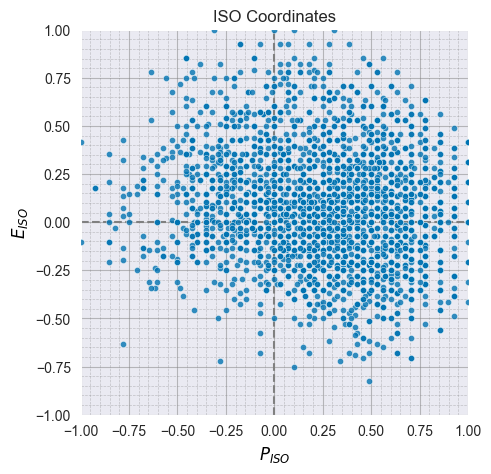

In [8]:
# Custom ISO coordinate calculation
custom_iso_data = sspy.surveys.add_iso_coords(
    valid_data,
    val_range=(1, 5),  # Specify the range of PAQ values
    names=("CustomPleasant", "CustomEventful"),  # Specify custom column names
    angles=(0, 45, 90, 135, 180, 225, 270, 315),  # Specify custom angles
    overwrite=True,  # Overwrite existing columns if they exist
)

# Compare the default and custom ISO coordinates
comparison_df = pd.DataFrame(
    {
        "ISOPleasant": valid_data_with_iso["ISOPleasant"],
        "CustomPleasant": custom_iso_data["CustomPleasant"],
        "ISOEventful": valid_data_with_iso["ISOEventful"],
        "CustomEventful": custom_iso_data["CustomEventful"],
    }
)

print("Comparison of default and custom ISO coordinates:")
print(comparison_df.head())

# Visualize the ISO coordinates
sspy.scatter(data=valid_data_with_iso, x="ISOPleasant", y="ISOEventful")
plt.title("ISO Coordinates")

## 4. Filtering and Grouping Data

Soundscapy provides several functions for filtering and grouping soundscape data based on various criteria.

In [9]:
# Filter by location
camden_data = isd.select_location_ids(valid_data_with_iso, "CamdenTown")
print(f"Camden Town samples: {camden_data.shape[0]}")

# Filter by multiple locations
multiple_locations = isd.select_location_ids(
    valid_data_with_iso, ["CamdenTown", "TateModern"]
)
print(f"Camden Town and Hyde Park samples: {multiple_locations.shape[0]}")

Camden Town samples: 105
Camden Town and Hyde Park samples: 257


### Complex Filtering with Pandas

You can also use pandas' query function for more complex filtering:

In [10]:
# Filter by demographic variables
if "gen00" in valid_data_with_iso.columns and "age00" in valid_data_with_iso.columns:
    women_over_50 = valid_data_with_iso.query("gen00 == 'Female' and age00 > 50")
    print(f"Women over 50: {women_over_50.shape[0]}")

# Filter by ISO coordinates
pleasant_soundscapes = valid_data_with_iso.query("ISOPleasant > 0.5")
print(f"Pleasant soundscapes (ISOPleasant > 0.5): {pleasant_soundscapes.shape[0]}")

Women over 50: 133
Pleasant soundscapes (ISOPleasant > 0.5): 886


### Grouping and Summarizing Data

You can use pandas' groupby function to group and summarize soundscape data:

In [12]:
# Group by location and calculate mean ISO coordinates
location_means = valid_data_with_iso.groupby("LocationID")[
    ["ISOPleasant", "ISOEventful"]
].mean()
print("Mean ISO coordinates by location:")
print(location_means.head())

# Calculate standard deviations
location_stds = valid_data_with_iso.groupby("LocationID")[
    ["ISOPleasant", "ISOEventful"]
].std()
print("\nStandard deviations of ISO coordinates by location:")
location_stds.head()

Mean ISO coordinates by location:
               ISOPleasant  ISOEventful
LocationID                             
CamdenTown       -0.102571     0.364096
CampoPrincipe     0.504940    -0.076165
CarloV            0.518265    -0.011537
DadongSquare      0.288473    -0.004974
EustonTap        -0.211265     0.190242

Standard deviations of ISO coordinates by location:


,ISOPleasant,ISOEventful
LocationID,,
CamdenTown,0.289155,0.344868
CampoPrincipe,0.299031,0.336325
CarloV,0.293737,0.317614
DadongSquare,0.255875,0.219590
EustonTap,0.282400,0.308316


### Using the soundscapy_describe Function

Soundscapy provides a `soundscapy_describe` function that summarizes soundscape data by location:

In [14]:
# Describe locations
location_summary = isd.soundscapy_describe(valid_data_with_iso)
print("Soundscape summary by location:")
location_summary.head()

Soundscape summary by location:


,count,ISOPleasant,ISOEventful,pleasant,eventful,vibrant,chaotic,monotonous,calm
CarloV,116,0.518,-0.012,0.940,0.448,0.397,0.052,0.009,0.534
SanMarco,96,0.221,0.373,0.750,0.875,0.656,0.219,0.010,0.094
PlazaBibRambla,18,0.463,-0.023,0.889,0.556,0.444,0.056,0.000,0.444
CamdenTown,105,-0.103,0.364,0.390,0.905,0.333,0.562,0.038,0.057
EustonTap,100,-0.211,0.190,0.250,0.750,0.180,0.570,0.140,0.070


In [15]:
# Describe a specific location
camden_summary = isd.describe_location(valid_data_with_iso, "CamdenTown")
print("\nCamden Town summary:")
for key, value in camden_summary.items():
    print(f"{key}: {value}")


Camden Town summary:
count: 105
ISOPleasant: -0.103
ISOEventful: 0.364
pleasant: 0.39
eventful: 0.905
vibrant: 0.333
chaotic: 0.562
monotonous: 0.038
calm: 0.057


## 5. Working with Different Survey Formats and Scales

Soundscape surveys may use different scales for PAQ ratings. Soundscapy can handle different scales by specifying the value range when calculating ISO coordinates.

In [17]:
# Create a sample dataset with a different scale (0-100)
sample_data = pd.DataFrame(
    {
        "RecordID": ["EX1", "EX2", "EX3"],
        "PAQ1": [80, 60, 90],
        "PAQ2": [70, 50, 85],
        "PAQ3": [60, 40, 80],
        "PAQ4": [50, 30, 75],
        "PAQ5": [40, 20, 70],
        "PAQ6": [30, 10, 65],
        "PAQ7": [20, 0, 60],
        "PAQ8": [10, 5, 55],
    }
)

# Calculate ISO coordinates with a different scale
sample_data_with_iso = sspy.surveys.add_iso_coords(
    sample_data,
    val_range=(0, 100),  # Specify the range of PAQ values
    names=("ISOPleasant", "ISOEventful"),
    overwrite=True,
)

print("Sample data with ISO coordinates (0-100 scale):")
sample_data_with_iso[["ISOPleasant", "ISOEventful"]]

Sample data with ISO coordinates (0-100 scale):


,ISOPleasant,ISOEventful
0,0.165685,0.400000
1,0.209619,0.356066
2,0.082843,0.200000


In [20]:
# Create a sample dataset with different column names
sample_data_2 = pd.DataFrame(
    {
        "RecordID": ["EX1", "EX2", "EX3"],
        "Pleasant": [4, 2, 5],
        "Vibrant": [3, 1, 4],
        "Eventful": [2, 3, 3],
        "Chaotic": [1, 4, 2],
        "Annoying": [2, 5, 1],
        "Monotonous": [3, 4, 2],
        "Uneventful": [4, 3, 3],
        "Calm": [5, 2, 4],
    }
)

# Rename columns to match PAQ format
paq_mapping = {
    "Pleasant": "PAQ1",
    "Vibrant": "PAQ2",
    "Eventful": "PAQ3",
    "Chaotic": "PAQ4",
    "Annoying": "PAQ5",
    "Monotonous": "PAQ6",
    "Uneventful": "PAQ7",
    "Calm": "PAQ8",
}
sample_data_2_renamed = rename_paqs(sample_data_2, paq_mapping)

# Calculate ISO coordinates
sample_data_2_with_iso = sspy.surveys.add_iso_coords(sample_data_2_renamed)

print("Sample data with renamed columns and ISO coordinates:")
sample_data_2_with_iso[["ISOPleasant", "ISOEventful"]]

Sample data with renamed columns and ISO coordinates:


,ISOPleasant,ISOEventful
0,0.500000,-5.000000e-01
1,-0.676777,-7.322330e-02
2,0.707107,-5.748368e-17


## 6. Handling Multi-Language Data

Soundscape perception can vary across languages and cultures. Soundscapy provides language-specific angles for calculating ISO coordinates that account for these differences.

In [21]:
# Display the available language-specific angles
print("Available language-specific angles:")
for language, angles in LANGUAGE_ANGLES.items():
    print(f"{language}: {angles}")

Available language-specific angles:
eng: (0, 46, 94, 138, 177, 241, 275, 340)
arb: (0, 36, 45, 135, 167, 201, 242, 308)
cmn: (0, 18, 38, 154, 171, 196, 217, 318)
hrv: (0, 84, 93, 160, 173, 243, 273, 354)
nld: (0, 43, 111, 125, 174, 257, 307, 341)
deu: (0, 64, 97, 132, 182, 254, 282, 336)
ell: (0, 72, 86, 133, 161, 233, 267, 328)
ind: (0, 53, 104, 123, 139, 202, 284, 308)
ita: (0, 57, 104, 143, 170, 274, 285, 336)
spa: (0, 41, 103, 147, 174, 238, 279, 332)
swe: (0, 66, 87, 146, 175, 249, 275, 335)
tur: (0, 55, 97, 106, 157, 254, 289, 313)


### Applying Language-Specific Angles

You can apply language-specific angles when calculating ISO coordinates:

In [23]:
# Calculate ISO coordinates with language-specific angles
english_angles = LANGUAGE_ANGLES["eng"]
spanish_angles = LANGUAGE_ANGLES["spa"]

# Using English angles
english_iso_data = sspy.surveys.add_iso_coords(
    valid_data,
    angles=english_angles,
    names=("English_Pleasant", "English_Eventful"),
    overwrite=True,
)

# Using Spanish angles
spanish_iso_data = sspy.surveys.add_iso_coords(
    valid_data,
    angles=spanish_angles,
    names=("Spanish_Pleasant", "Spanish_Eventful"),
    overwrite=True,
)

# Compare the results
comparison_df = pd.DataFrame(
    {
        "English_Pleasant": english_iso_data["English_Pleasant"],
        "Spanish_Pleasant": spanish_iso_data["Spanish_Pleasant"],
        "English_Eventful": english_iso_data["English_Eventful"],
        "Spanish_Eventful": spanish_iso_data["Spanish_Eventful"],
    }
)

print("Comparison of ISO coordinates with different language angles:")
comparison_df.head()

Comparison of ISO coordinates with different language angles:


,English_Pleasant,Spanish_Pleasant,English_Eventful,Spanish_Eventful
0,0.208674,0.237632,-0.143577,-0.130332
1,-0.442699,-0.446764,0.467938,0.472546
2,0.637149,0.614498,0.001787,0.003579
3,0.588840,0.565269,-0.092234,-0.088906
4,0.445299,0.428558,-0.126446,-0.120598


### Applying Language-Specific Angles to a Mixed-Language Dataset

If your dataset contains responses in multiple languages, you can apply the appropriate angles for each language:

In [26]:
# Filter data for English and Spanish languages
if "Language" in valid_data_with_iso.columns:
    eng_data = valid_data_with_iso[valid_data_with_iso["Language"] == "eng"]
    spa_data = valid_data_with_iso[valid_data_with_iso["Language"] == "spa"]

    print(f"English responses: {eng_data.shape[0]}")
    print(f"Spanish responses: {spa_data.shape[0]}")

English responses: 1280
Spanish responses: 223


In [27]:
# Function to apply language-specific angles to each row
def apply_language_angles(row):
    if "Language" not in row or row["Language"] not in LANGUAGE_ANGLES:
        return sspy.surveys.calculate_iso_coords(
            row[PAQ_IDS], angles=LANGUAGE_ANGLES["eng"]
        )
    return sspy.surveys.calculate_iso_coords(
        row[PAQ_IDS], angles=LANGUAGE_ANGLES[row["Language"]]
    )

```python
# Example of applying this function (commented out as it depends on the dataset structure)
# Apply language-specific angles to each row
if 'Language' in valid_data_with_iso.columns:
    # Apply the function to each row
    results = valid_data_with_iso.apply(apply_language_angles, axis=1)
    
    # Extract the results
    valid_data_with_iso['Lang_ISOPleasant'] = [r[0] for r in results]
    valid_data_with_iso['Lang_ISOEventful'] = [r[1] for r in results]
    
    print("ISO coordinates with language-specific angles:")
    print(valid_data_with_iso[['Lang_ISOPleasant', 'Lang_ISOEventful']].head())
```

## 7. Simulating Soundscape Data

Soundscapy provides a function for simulating soundscape data, which can be useful for testing and demonstration purposes.

Simulated soundscape data:
   PAQ1  PAQ2  PAQ3  PAQ4  PAQ5  PAQ6  PAQ7  PAQ8  ISOPleasant  ISOEventful
0     1     2     1     5     2     4     4     3    -0.396447    -0.310660
1     5     3     2     2     3     2     1     3     0.353553     0.103553
2     5     1     1     5     5     3     1     2    -0.366117     0.073223
3     1     3     3     3     3     3     1     2    -0.280330     0.280330
4     5     4     3     2     4     2     1     5     0.469670     0.133883


<Axes: title={'center': 'Simulated Soundscape Data'}, xlabel='$P_{ISO}$', ylabel='$E_{ISO}$'>

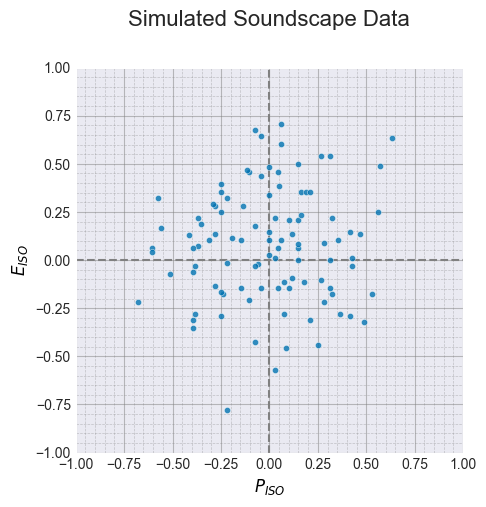

In [28]:
# Simulate soundscape data
simulated_data = sspy.surveys.simulation(
    n=100,  # Number of samples
    val_range=(1, 5),  # Range of PAQ values
    incl_iso_coords=True,  # Include ISO coordinates
)

print("Simulated soundscape data:")
print(simulated_data.head())

# Visualize the simulated data
sspy.scatter(simulated_data, title="Simulated Soundscape Data")

## 8. Conclusion

In this tutorial, we've covered the essential aspects of working with soundscape survey data using the Soundscapy package:

1. **Loading Data**: We learned how to load data from the built-in ISD dataset and from external sources.
2. **Data Validation**: We explored how to validate and clean soundscape data to ensure quality.
3. **ISO Coordinates**: We calculated ISO coordinates from PAQ ratings and customized the calculation.
4. **Filtering and Grouping**: We filtered and grouped data based on various criteria.
5. **Different Scales**: We worked with different survey formats and scales.
6. **Multi-Language Data**: We applied language-specific angles to account for cultural differences.
7. **Simulation**: We simulated soundscape data for testing and demonstration.

These tools and techniques provide a solid foundation for analyzing soundscape survey data and can be applied to a wide range of research questions and datasets.